In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pylab as plt

from sklearn.feature_selection import (VarianceThreshold, RFE, SelectFromModel)
from sklearn.svm import (SVC, LinearSVC)
from sklearn.linear_model import (LogisticRegression)
from sklearn.metrics import (roc_curve, roc_auc_score, precision_recall_curve, auc, make_scorer, 
                             recall_score, accuracy_score, precision_score, confusion_matrix)

# Import Data
<br>
The data contain bacteria counts from all taxonomic levels (i.e. phylum, class, order, family, genus, species) as features for each patient. 

In [2]:
bacteria_data = pd.read_csv("C:/Users/Jennifer Chen/Documents/course documents/spring 2020/ibd project/data/bacteria_data.csv")

In [3]:
# preprocessing

bacteria_data = bacteria_data.set_index('SampleID').drop(columns = ['Disease', 'Tissue', 'Region', 'Pathology', 'Subtype',
                                                                    'Location', 'Behavior', 'SmokingStatus', 'X5_ASA', 'Steroids', 
                                                                    'Immunomodulators', 'TNF', 'Cohort'])
bacteria_data.rename(columns = {'Recurrence2':'Recurrence'}, inplace = True) 
bacteria_data = bacteria_data.drop(bacteria_data[bacteria_data.Recurrence == ' '].index)

print(bacteria_data.shape)
bacteria_data[:5]

(84, 13590)


,Firmicutes.Clostridia.Clostridiales.Lachnospiraceae.Roseburia.Species_2,Firmicutes.Clostridia.Clostridiales.Lachnospiraceae.Roseburia.Species_3,Firmicutes.Clostridia.Clostridiales.Lachnospiraceae.Roseburia.Species_4,Firmicutes.Clostridia.Clostridiales.Lachnospiraceae.Roseburia.Species_6,Firmicutes.Clostridia.Clostridiales.Lachnospiraceae.Roseburia.Species_7,Firmicutes.Clostridia.Clostridiales.Lachnospiraceae.Roseburia.Species_8,Firmicutes.Clostridia.Clostridiales.Lachnospiraceae.Roseburia.Species_11,Firmicutes.Clostridia.Clostridiales.Lachnospiraceae.Roseburia.Species_14,Firmicutes.Clostridia.Clostridiales.Lachnospiraceae.Roseburia.Species_17,Firmicutes.Clostridia.Clostridiales.Lachnospiraceae.Roseburia.Species_23,...,Bacteroidetes.Flavobacteriia.1,Firmicutes.Negativicutes.1,Fusobacteria.Fusobacteriia.1,Firmicutes.Clostridia.1,Recurrence,Aerobic,Anaerobic,Facultative Anaerobic Microaerophilic,Obligate Aerobic,Obligate Anaerobic
SampleID,,,,,,,,,,,,,,,,,,,,,
X1122.CD.NI.ileum.WashU,0,0,0,0,0,0.0,0,0.000000,0,0.0,...,0.006993,0.005358,0.001871,0.000000,recurrence,0.193953,0.000251,0.639882,0.000974,0.145673
X124.CD.NI.ileum.WashU,0,0,0,0,0,0.0,0,0.222174,0,0.0,...,0.000000,0.078829,0.001557,0.028114,recurrence,0.001532,0.006649,0.078479,0.000419,0.901949
X1276.CD.NI.ileum.WashU,0,0,0,0,0,0.0,0,0.000000,0,0.0,...,0.020979,0.143594,0.000942,0.108471,no recurrence,0.007719,0.130694,0.131722,0.001932,0.724267
X1287.CD.NI.ileum.WashU,1,0,0,0,0,0.0,0,0.000000,0,0.0,...,0.000000,0.137488,0.000151,0.031010,recurrence,0.000116,0.014527,0.011776,0.000116,0.973425
X129.CD.NI.ileum.UNC,0,0,0,0,0,0.0,0,0.011625,0,0.0,...,0.024476,0.007761,0.000000,0.155682,no recurrence,0.011995,0.003438,0.021855,0.013971,0.938168


In [4]:
bacteria_data['Recurrence'] = bacteria_data['Recurrence'].map({'recurrence': 1, 'no recurrence': 0})

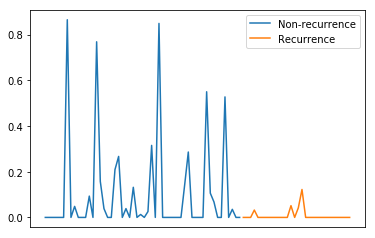

In [22]:
plt.xticks([])
plt.plot(bacteria_data[bacteria_data.Recurrence == 0]['Proteobacteria.Betaproteobacteria.Neisseriales.Neisseriaceae.Neisseria'])
plt.plot(bacteria_data[bacteria_data.Recurrence == 1]['Proteobacteria.Betaproteobacteria.Neisseriales.Neisseriaceae.Neisseria'])
plt.legend(labels = ['Non-recurrence', 'Recurrence'])

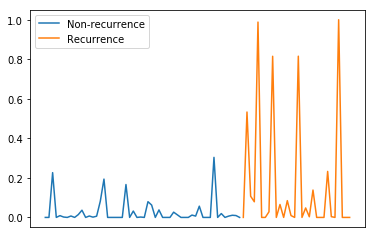

In [21]:
plt.xticks([])
plt.plot(bacteria_data[bacteria_data.Recurrence == 0]['Firmicutes.Clostridia.Clostridiales.Peptostreptococcaceae.Clostridium_XI.difficile'])
plt.plot(bacteria_data[bacteria_data.Recurrence == 1]['Firmicutes.Clostridia.Clostridiales.Peptostreptococcaceae.Clostridium_XI.difficile'])
plt.legend(labels = ['Non-recurrence', 'Recurrence'])

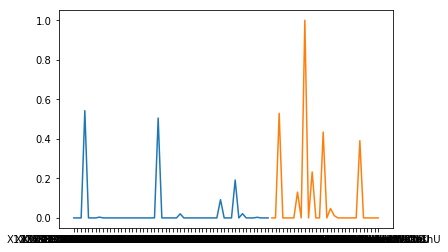

In [14]:
plt.plot(bacteria_data[bacteria_data.Recurrence == 0]['Bacteroidetes.Bacteroidia.Bacteroidales.Porphyromonadaceae.Coprobacter'])
plt.plot(bacteria_data[bacteria_data.Recurrence == 1]['Bacteroidetes.Bacteroidia.Bacteroidales.Porphyromonadaceae.Coprobacter'])

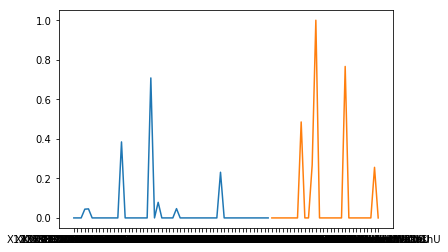

In [12]:
plt.plot(bacteria_data[bacteria_data.Recurrence == 0]['Bacteroidetes.Bacteroidia.Bacteroidales.Bacteroidaceae.Bacteroides.Species_19718'])
plt.plot(bacteria_data[bacteria_data.Recurrence == 1]['Bacteroidetes.Bacteroidia.Bacteroidales.Bacteroidaceae.Bacteroides.Species_19718'])

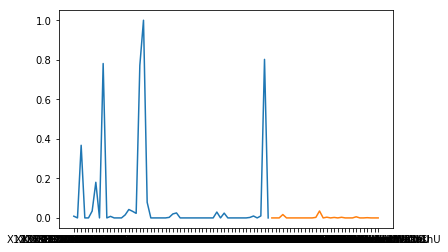

In [15]:
plt.plot(bacteria_data[bacteria_data.Recurrence == 0][ 'Proteobacteria.Betaproteobacteria.Burkholderiales.Sutterellaceae.Sutterella.Species_14902'])
plt.plot(bacteria_data[bacteria_data.Recurrence == 1][ 'Proteobacteria.Betaproteobacteria.Burkholderiales.Sutterellaceae.Sutterella.Species_14902'])

# Function for Leave-oue-out Cross Validation

In [11]:
feature_count = {}

In [6]:
def leave_one_out_cv(data, filter_threshold, select_method, num_feature, svc_penalty):

    ys_test = []
    ys_predicted = []
    dec_func = []
    
    for i in data.index.values:
        
        test_data = data.loc[i]
        train_data = data.drop(index=i)
        y_test = test_data['Recurrence']
        X_test = test_data.drop(columns=['Recurrence'])
        y_train = train_data['Recurrence']
        X_train = train_data.drop(columns=['Recurrence'])
        
        # feature filtering
        X_train = X_train.loc[:, (np.count_nonzero(X_train, axis=0) > filter_threshold)]

        if select_method=='rfe':
            # select with recursive feature elimination
            selector = RFE(estimator=SVC(kernel='linear', C=1), n_features_to_select=num_feature, step=10).fit(X_train, y_train)
        
        elif select_method == 'logreg':
            # select with model: logistic regression
            selector = SelectFromModel(estimator=LogisticRegression(penalty='l1', solver='saga'), max_features=num_feature).fit(X_train, y_train)
            
        else:
            # select with model: linear svc     
            lsvc = LinearSVC(C=1, penalty='l1', dual=False)
            selector = SelectFromModel(estimator=lsvc, max_features=num_feature).fit(X_train, y_train)

        # selected features
        selected_features = X_train.columns[selector.get_support()]
        
        # transform X_train and X_test
        X_train = X_train[selected_features]
        X_test = [X_test[selected_features]]
        
        # train the model 
        classifier = SVC(C=svc_penalty, kernel='linear').fit(X_train, y_train)

        # make prediction
        y_predicted = classifier.predict(X_test)
            
        # keep lists for y_test, y_predicted, prediction accuracy (T or F), and decision functions for every LOL test
        ys_test.append(y_test)
        ys_predicted.append(y_predicted)
        dec_func.append(classifier.decision_function(X_test))
            
        # use a dictionary to keep the number of times a feature is selected   
        for feature in selected_features:
            if feature not in feature_count.keys():
                feature_count[feature] = 0
            feature_count[feature] += 1
            
    print('accuracy:', accuracy_score(ys_test, ys_predicted))
    print('precision:', precision_score(ys_test, ys_predicted))
    print('recall:', recall_score(ys_test, ys_predicted))
        
    plot_confusion_matrix(ys_test, ys_predicted, ['no recurrence','recurrence'])
        
    fpr, tpr, threhold = roc_curve(ys_test, dec_func, pos_label = 1)
    plot_roc_curve(fpr, tpr)
    print('Area under the roc curve:', roc_auc_score(ys_test, dec_func))
    
    return

C:\Users\Jennifer Chen\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Jennifer Chen\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Jennifer Chen\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Jennifer Chen\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Jennifer Chen\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number o

accuracy: 0.7023809523809523
precision: 0.6470588235294118
recall: 0.36666666666666664
Area under the roc curve: 0.5641975308641974


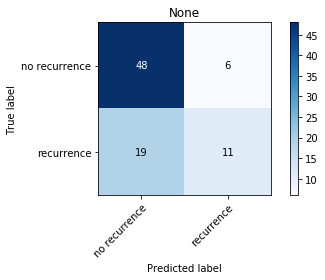

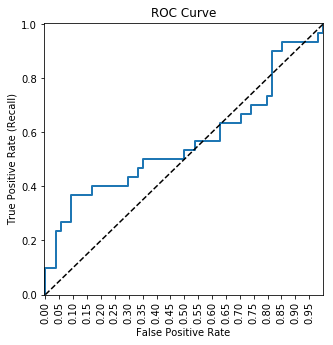

In [20]:
feature_score = leave_one_out_cv(bacteria_data, filter_threshold=5, select_method='lsvc', num_feature=20, svc_penalty=10)

In [21]:
feature_count_copy = feature_count
{feature_count_copy: v for feature_count_copy, v in sorted(feature_count_copy.items(), key=lambda item: item[1], reverse=True)}

{'Firmicutes.Clostridia.Clostridiales.Peptostreptococcaceae.Clostridium_XI.difficile': 420,
 'Proteobacteria.Betaproteobacteria.Neisseriales.Neisseriaceae.Neisseria': 419,
 'Bacteroidetes.Bacteroidia.Bacteroidales.Porphyromonadaceae.Coprobacter.Species_19043': 374,
 'Bacteroidetes.Bacteroidia.Bacteroidales.Porphyromonadaceae.Coprobacter': 374,
 'Bacteroidetes.Bacteroidia.Bacteroidales.Bacteroidaceae.Bacteroides.Species_19718': 359,
 'Firmicutes.Clostridia.Clostridiales.Clostridiales_Incertae_Sedis_XIII': 336,
 'Bacteroidetes.Bacteroidia.Bacteroidales.Porphyromonadaceae.Parabacteroides.Species_18948': 329,
 'Firmicutes.Clostridia.Clostridiales.Peptostreptococcaceae.Romboutsia.Species_23587': 326,
 'Proteobacteria.Betaproteobacteria.Burkholderiales.Sutterellaceae.Sutterella.Species_14902': 322,
 'Bacteroidetes.Bacteroidia.Bacteroidales.Porphyromonadaceae.Parabacteroides.Species_18978': 308,
 'Firmicutes.Bacilli.Lactobacillales.Streptococcaceae.Streptococcus.constellatus': 285,
 'Proteoba

Text(0,0.5,'Times selected')

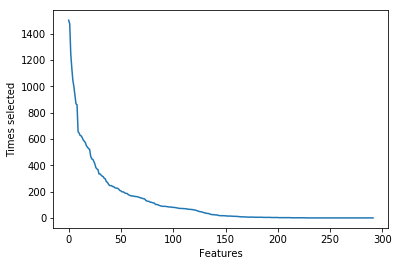

In [43]:
counts = list(feature_count.values())
plt.plot(sorted(counts, reverse=True))
plt.xlabel('Features')
plt.ylabel('Times selected')

In [8]:
# Helper functions

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):

    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(5,5))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")